<h1 align="center">Pozo de potencial finito</h1>
<div align="right">David A. Miranda, PhD<br>2023</div>

## 1. Cargar librerías

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import constants as ct
import scipy.optimize as op

## 2. Planteamiento del problema

Sea una partícula cuántica descrita por la función de onda $\psi_n(x)$ en un pozo de potencial finito con altura $U_0$. 

+ Obtenga y grafique las funciones propias para el operador hamiltoniano $\hat{H}$ del sistema.
+ Grafique los valores de energía permitidos.

## 3. Métodos y definiciones

In [2]:
a = 10   # nm -> ancho del pozo de potencial
Uo = 10   # eV -> altura del pozo de potencial
m  = ct.m_e / ct.e * 1e-18 # eV/[c^2] -> masa del electrón, con velocidad de la luz c en nm/s
hbar = ct.physical_constants['Planck constant in eV/Hz'][0]
dpi = 300

In [3]:
def well_wavenumbers(well_width, Uo, N=20, tol=1e-7, digits=6, wavefunction_type='even'):
    a = well_width
    k_critical = np.sqrt(2 * m * Uo) / hbar
    k0 = [np.pi * (n + 1) / (2*a) for n in range(N)]
    def knorm(k):
        kk = (k/k_critical)**2
        if wavefunction_type == 'even':
            return kk
        if wavefunction_type == 'odd':
            return 1 - kk
    dfunc = np.cos if wavefunction_type == 'odd' else lambda x: -np.sin(x)
    root_func = lambda k: (np.cos(k*a/2))**2 - knorm(k)
    dfunc1 = lambda k: a * dfunc(k*a) 
    k = op.newton(
        root_func,
        k0,
        fprime=dfunc1,
        tol=tol,
        maxiter=10000)
    k = k[np.abs(root_func(k)) <= tol] # Verifica que la raiz sea válida
    k = k[k > 0] # Por definición, k es positiva, por ello, se descartan los valores negativos
    k = np.sort( np.unique( np.round(k, digits) ) ) # Ordena de menor a mayor y deja solo los términos diferentes
    if wavefunction_type == 'even':
        return k[np.tan(k*a/2)>0]#[0:-1:2]
    if wavefunction_type == 'odd':
        return k[np.tan(k*a/2)<0]#[0:-1:2]

In [4]:
def wavefunction_amplitudes(wave_number, well_width, Uo, wavefunction_type='even'):
    k = wave_number
    a = well_width
    q = np.abs(k * np.tan(k * a / 2) if wavefunction_type == 'even' else k / np.tan(k * a / 2))
    f = ( a + np.sin(a*k) / k ) / 2
    g = np.cos(k * a / 2)
    if wavefunction_type == 'odd':
        f = ( a - np.sin(a*k) / k ) / 2
        g = np.sin(k * a / 2)
    ψ0 = np.sqrt( q / ( 2 * q * f + g**2 ) )
    ψ1 = ψ0 * g * np.exp(q * a / 2)
    return [ψ0, ψ1]

In [5]:
def wavefunction(x, k, well_width, Uo, tol=1e-6, wavefunction_type='even'):
    a = well_width
    q = np.abs(k * np.tan(k * a / 2) if wavefunction_type == 'even' else k / np.tan(k * a / 2))
    E = hbar**2 * k**2 / (2 * m)
    func = np.sin if wavefunction_type == 'odd' else np.cos
    ψ0, ψ1 = wavefunction_amplitudes(k, well_width, Uo, wavefunction_type=wavefunction_type)
    ψ = func( k * x )
    if E > Uo:
        return ψ, E
    i = np.abs(x) <= a/2
    ψ[i] = ψ0 * func( k * x[i] )
    i = np.abs(x) > a/2
    ψ[i]  = ψ1 * np.exp( - np.abs(q * x[i]) )
    if wavefunction_type == 'odd':
        i = x < - a/2
        ψ[i]  = - ψ1 * np.exp( - np.abs( q* x[i] ) )
    return ψ, E

In [6]:
def get_eigen(x, a, Uo, N=100):
    eigen_funcs = []
    eigen_vals = []
    for wavefunction_type in ['even', 'odd']:
        for k in well_wavenumbers(a, Uo, N=N, wavefunction_type=wavefunction_type):
            ψ, E = wavefunction(
                x, 
                k, 
                a, 
                Uo, 
                wavefunction_type=wavefunction_type)
            if np.isnan(E):
                continue
            eigen_funcs.append(ψ)
            eigen_vals.append(E)
    idxs = np.argsort(eigen_vals)
    eigen_funcs = [eigen_funcs[i] for i in idxs]
    eigen_vals  = [eigen_vals[i]  for i in idxs]
    return eigen_vals, eigen_funcs

## 4. Funciones y valores propios de $\hat{H}$

### 4.1. Solución analítica

Supongamos que la energía potencial es cero dentro del pozo de potencial y $U_0$ fuera de este, entonces, el espacio se divide en dos zonas, la zona dentro del pozo, donde la energía potencial $U(x) = 0$, con hamiltoniano es $\hat{H}_0 = - \frac{\hbar^2}{2m} \frac{d^2}{dx^2}$ y la zona fuera del pozo, donde la energía $U(|x| \geq a/2) = U_0$, con hamiltoniano $\hat{H}_1 = - \frac{\hbar^2}{2m} \frac{d^2}{dx^2} + U_0$.

#### 4.1.1. Funciones propias para $\hat{H}_0$

Las funciones propias $\psi_n(x)$ del operador $\hat{H}_0$ satisfasen la ecuación $\hat{H}_0 \psi_n(x) = E_n \psi_n(x)$, donde $E_n$ son los valores propios y corresponden con la energía total permitida. Las funciones propias se encuentran al solucionar la ecuación diferencial $-\frac{\hbar^2}{2m} \frac{d^2}{dx^2} \psi_n(x) = E_n \psi_n(x)$ y corresponden con:

$$ \psi(x) = \psi_n^{(par)}(x) = \alpha_n cos(k_n x) \,\, \forall \,\, |x| \leq a/2 \qquad (1)$$
$$ \varphi(x) = \psi_{n}^{(impar)}(x) = \alpha'_{n'} sin(k_{n'} x) \,\, \forall \,\, |x| \leq a/2 \qquad (2)$$
$$ E_n = \frac{\hbar^2}{2m} k_n^2 \qquad (3)$$

#### 4.1.2. Funciones propias para $\hat{H}_1$

Hay dos posibles casos, cuando $E_n < U_0$ y cuando $E_n > U_0$.

+ **Caso 1: $0 < E_n < U_0$**. En este caso la partícula está confinada por el pozo de potencial.

$$ \psi_n(x) = \beta_n e^{-q|x|} \,\, \forall \,\, |x| \geq a/2 \qquad (4)$$
$$ E_n = U_0 - \frac{\hbar^2}{2m} q_n^2 \qquad (5)$$

+ **Caso 2: $E_n > U_0$**. En este caso la partícula está libre y el pozo de potencial actúa como un agente dispersor, sobre todo si la energía $E_n$ es cercana a $U_0$.

$$ \psi_n(x) = \gamma_n e^{iqx} + \gamma_n^* e^{-iqx} \,\, \forall \,\, |x| \geq a/2 \qquad (4)$$
$$ E_n = U_0 + \frac{\hbar^2}{2m} q_n^2 \qquad (5)$$


#### 4.1.3. Empalme de soluciones

Dado que en las fronteras $x= \pm a/2$ las funciones propias de $\hat{H}_0$ deben coincidir con las de  $\hat{H}_1$, así como sus primeras derivadas, entonces, los números de onda $k$ y $q$ deben satisfacer las siguientes relaciones para $0 < E_n < U_0$.

+ Solución par:

$$ cos^2(ka/2) = \frac{\hbar^2 k^2}{2 m Uo} \qquad (6a)$$
$$ q = k \, tan(ka/2) \Rightarrow tan(ka/2) > 0 \qquad (6b)$$

+ Solución impar:

$$ sen^2(ka/2) = \frac{\hbar^2 k^2}{2 m Uo} \qquad (7a)$$
$$ q = - k / tan(ka/2) \Rightarrow tan(ka/2) < 0 \qquad (7b)$$

### 4.2. Funciones de onda y energía total

/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:6: RuntimeWarning: overflow encountered in square
  kk = (k/k_critical)**2
/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:12: RuntimeWarning: invalid value encountered in cos
  root_func = lambda k: (np.cos(k*a/2))**2 - knorm(k)
/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:11: RuntimeWarning: invalid value encountered in sin
  dfunc = np.cos if wavefunction_type == 'odd' else lambda x: -np.sin(x)
/Users/david/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/zeros.py:459: RuntimeWarning: some failed to converge after 10000 iterations
  warnings.warn(msg, RuntimeWarning)
/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:13: RuntimeWarning: invalid value encountered in cos
  dfunc1 = lambda k: a * dfunc(k*a)


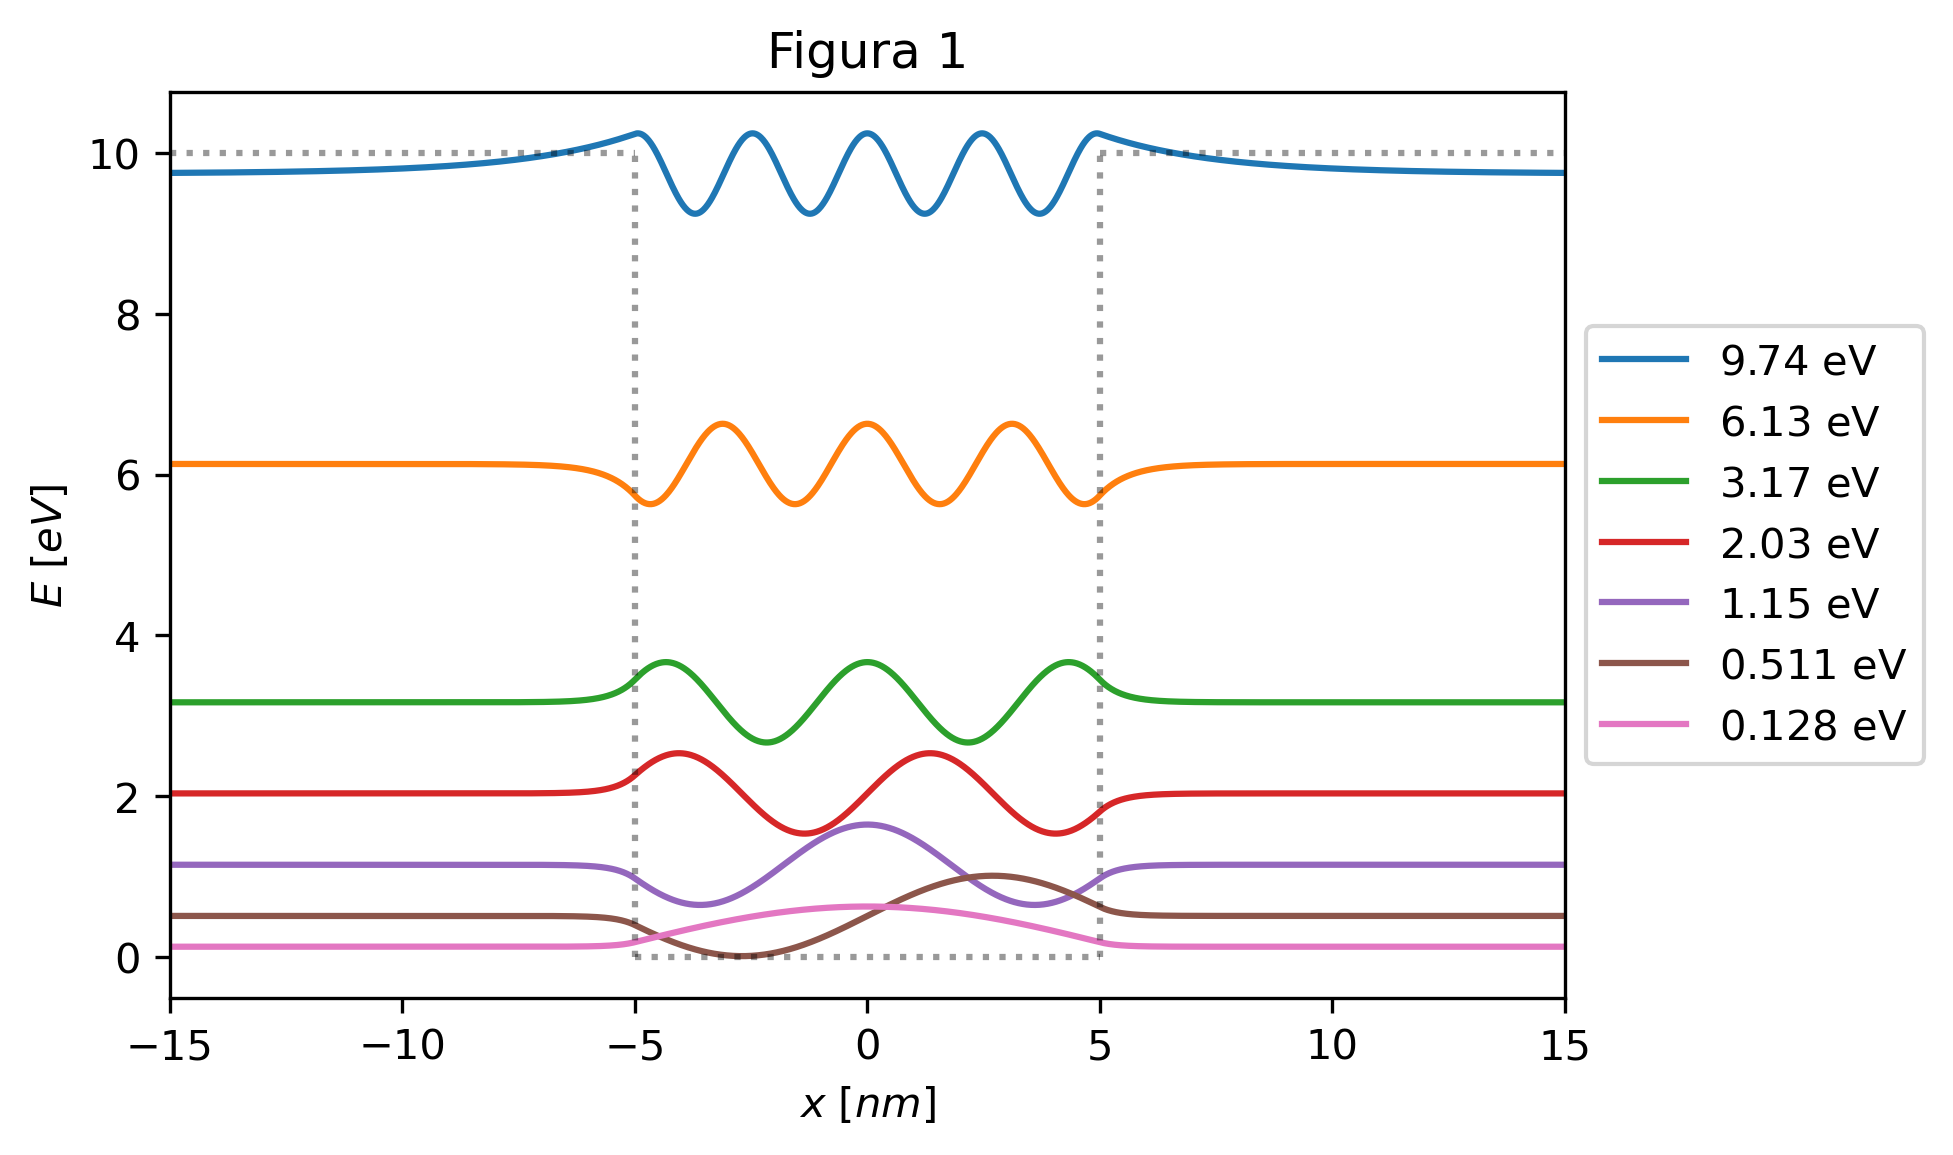

In [7]:
x = np.linspace(-1.5*a, 1.5*a, 2000)
eigen_vals, eigen_funcs = get_eigen(x, a, Uo, N=100)
ψ_max = 0

plt.figure(dpi=dpi)
for E, ψ in zip(eigen_vals[::-1], eigen_funcs[::-1]):
    plt.plot(x, E + ψ/max(2*ψ), label=r'$%0.3g$ eV' % (E))
    if max(ψ) > ψ_max:
            ψ_max = max(ψ)
plt.vlines([-a/2, a/2], 0, Uo, colors='k', linestyles='dotted', alpha=0.4)
plt.hlines(0, -a/2, a/2, colors='k', linestyles='dotted', alpha=0.4)
plt.hlines(Uo, a/2, max(x), colors='k', linestyles='dotted', alpha=0.4)
plt.hlines(Uo, min(x),-a/2, colors='k', linestyles='dotted', alpha=0.4)

plt.xlim(min(x), max(x))
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.ylabel(r'$E$ $[eV]$')
plt.xlabel(r'$x$ $[nm]$')
_ = plt.title('Figura 1')

/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:6: RuntimeWarning: overflow encountered in square
  kk = (k/k_critical)**2
/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:12: RuntimeWarning: invalid value encountered in cos
  root_func = lambda k: (np.cos(k*a/2))**2 - knorm(k)
/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:11: RuntimeWarning: invalid value encountered in sin
  dfunc = np.cos if wavefunction_type == 'odd' else lambda x: -np.sin(x)
/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:13: RuntimeWarning: invalid value encountered in cos
  dfunc1 = lambda k: a * dfunc(k*a)
/Users/david/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/zeros.py:459: RuntimeWarning: some failed to converge after 10000 iterations
  warnings.warn(msg, RuntimeWarning)


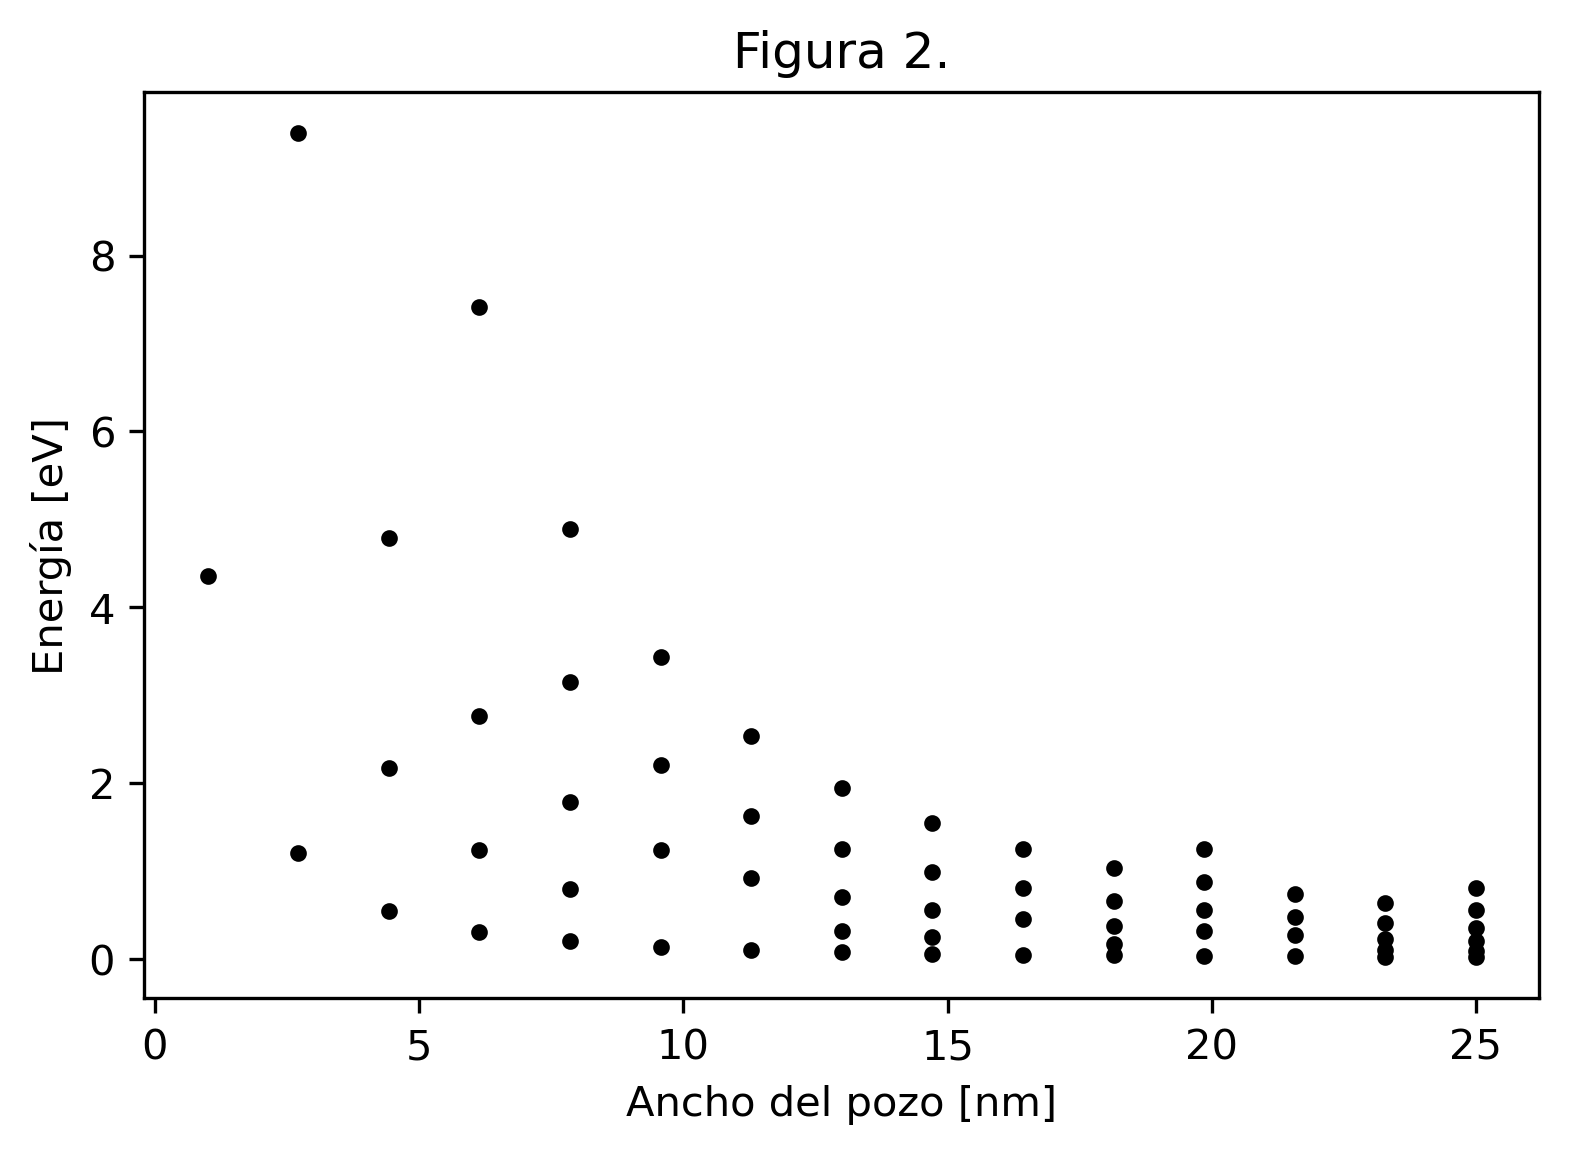

In [8]:
x = np.linspace(-1.5*a, 1.5*a, 2000)
well_widths = np.linspace(1, 25, 15)
energies = [ get_eigen(x, a, Uo, N=10)[0] for a in well_widths ]
L = max([len(E) for E in energies])
energies = [(L - len(E)) * [np.nan] + E for E in energies]

plt.figure(dpi=dpi)
plt.plot(well_widths, energies, '.k')
plt.xlabel('Ancho del pozo [nm]')
plt.ylabel('Energía [eV]')
_ = plt.title('Figura 2.')

/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:6: RuntimeWarning: overflow encountered in square
  kk = (k/k_critical)**2
/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:12: RuntimeWarning: invalid value encountered in cos
  root_func = lambda k: (np.cos(k*a/2))**2 - knorm(k)
/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:11: RuntimeWarning: invalid value encountered in sin
  dfunc = np.cos if wavefunction_type == 'odd' else lambda x: -np.sin(x)
/var/folders/mm/47m35qsx04v3zcpz9cfd8h740000gn/T/ipykernel_8340/2781091531.py:13: RuntimeWarning: invalid value encountered in cos
  dfunc1 = lambda k: a * dfunc(k*a)
/Users/david/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/zeros.py:459: RuntimeWarning: some failed to converge after 10000 iterations
  warnings.warn(msg, RuntimeWarning)


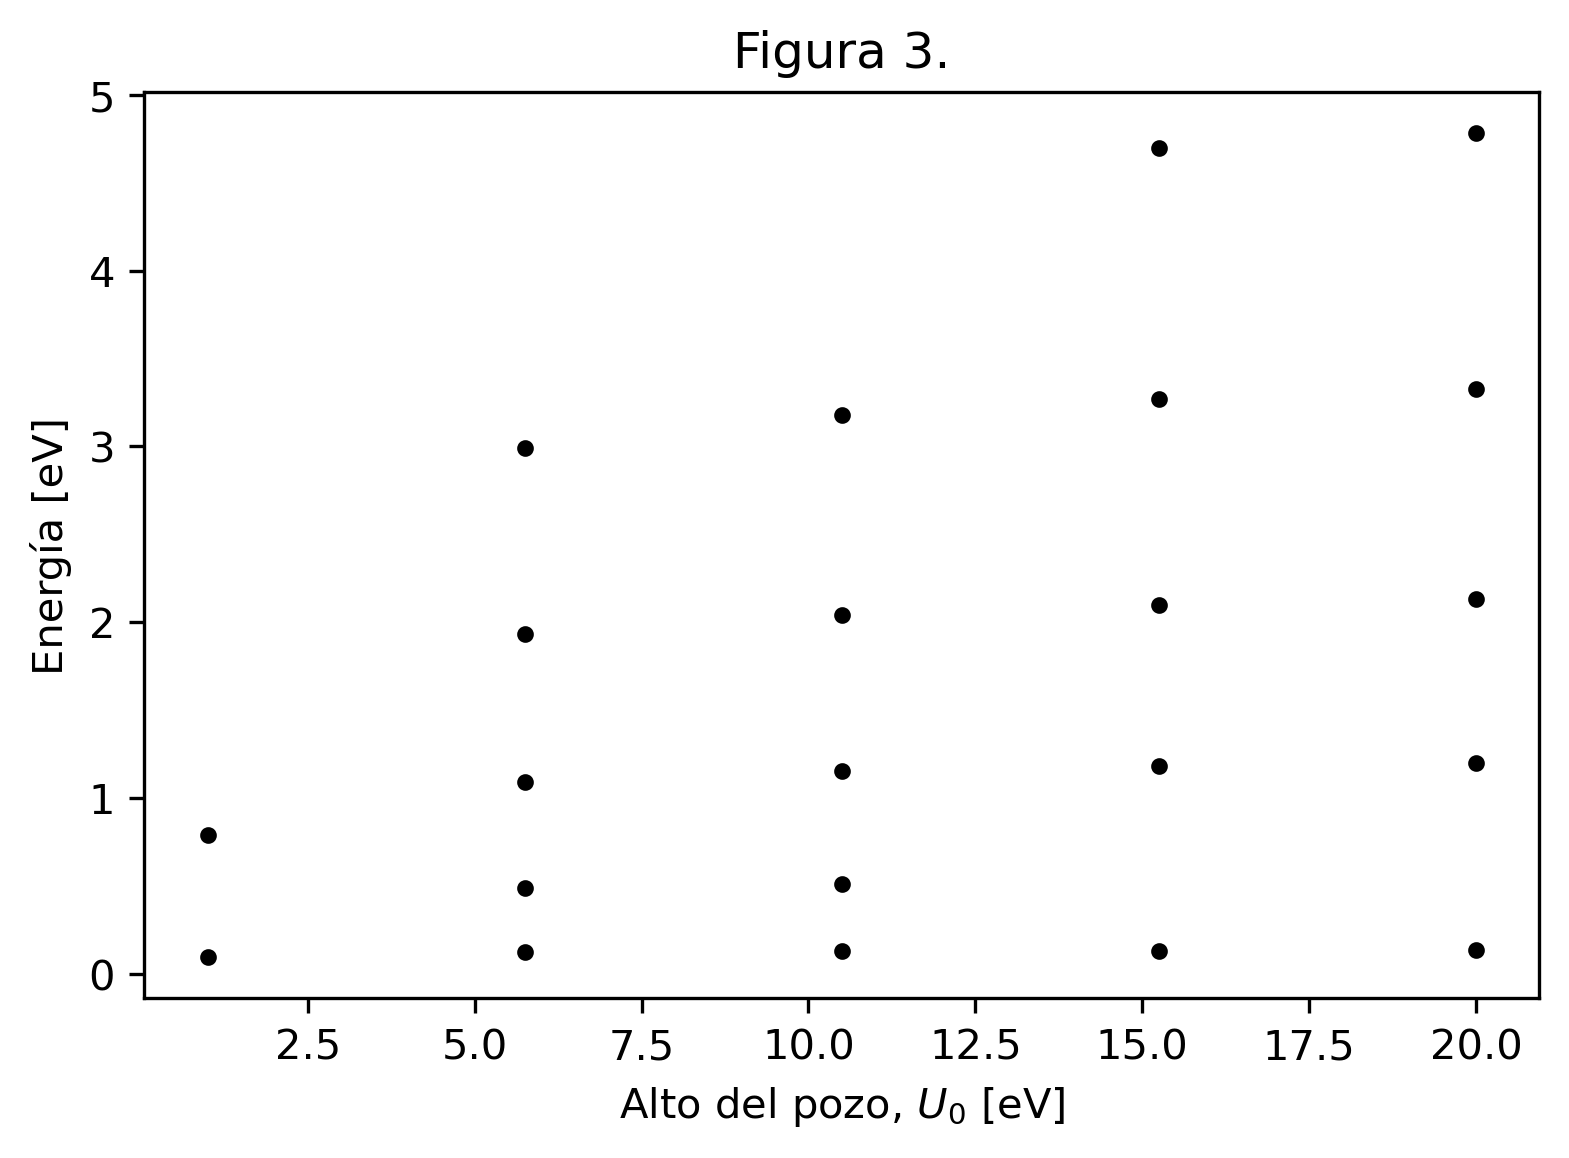

In [9]:
x = np.linspace(-1.5*a, 1.5*a, 2000)
well_highs = np.linspace(1, 20, 5)
energies = [ get_eigen(x, a, Uo, N=10)[0] for Uo in well_highs ]
L = max([len(E) for E in energies])
energies = [(L - len(E)) * [np.nan] + E for E in energies]

plt.figure(dpi=dpi)
plt.plot(well_highs, energies, '.k')
plt.xlabel(r'Alto del pozo, $U_0$ [eV]')
plt.ylabel('Energía [eV]')
_ = plt.title('Figura 3.')

## 5. Preguntas de autoexplicación

### 5.1. Primer bloque de preguntas

5.1.1. Explique, con sus propias palabras, el problema resuelto en este *Worked Example*.

5.1.2. ¿Cuál es la razón de considerar en el ítem 4.1.1 soluciones pares e impares?

5.1.3. En el ítem 4.1.2, ¿en qué se diferencia el caso 1 del caso 2?

5.1.4. Deduzca las ecuaciones (6a) a (7b).

5.1.5. ¿Cuál es la función de onda para los casos donde $E_n > U_0$? Argumente su respuesta.

### 5.2. Segundo bloque de preguntas

5.2.1. En el método *well_wavenumbers* se calcula *k_critical*. ¿Tiene este número algún sentido físico? Argumente su respuesta.

5.2.2. ¿Cuál es el propósito de definir *func* en el método *well_wavenumbers*?

5.2.3. El algoritmo de Newton-Raphson permite calcular las raices de una cierta función $f(x)$ conociendo su derivada $df(x)/d(x)$. En el método *well_wavenumbers* se utiliza el método *op.newton* que implementa el algoritmo de Newton-Raphson, tomando como función $f(k) = cos^2(ka/2) - \frac{\hbar^2 k^2}{2 m Uo}$ para la solución par y $f(k) = sen^2(ka/2) - \frac{\hbar^2 k^2}{2 m Uo}$, para el caso impar; además, como las pendientes debe ser iguales en la frontera, se toma como derivada $-a \sin(ka) / 2$ para la solución par y $a \cos(ka) / 2$, para la impar. ¿Cuál es el propósito de encontrar raices en la solución del problema mecánico cuántico resuelto en este *Worked Example*?


5.2.4. El método *wavefunction_amplitudes* retorna las constantes $\psi_0$ y $\psi_1$ que permiten que las funciones de onda sean continuas en las fronteras. Deduzca las expresiones utilizadas en dicho método y explique cómo se implementaron en el mismo.

5.2.5. Explique cómo se obtienen las funciones de onda con el método *wavefunction*.

### 5.3. Tercer bloque de preguntas

En la Figura 1 se muestran funciones de onda para diferentes números energías.

5.3.1. ¿Cuál es la relación entre la energía $E_n$ y el braket $\langle \psi_n |\hat{H} | \psi_n \rangle$.  

5.3.2. ¿Cómo interpreta que el valor medio de cada función de onda concuerde con un cierto valor de energía (eje de las ordenadas)?

5.3.3. ¿Cómo se relacionan las funciones de onda pares e impares con la energía total de la partícula cuántica?

5.3.4. ¿Cuál es el efecto de variar la altura $U_0$ del pozo de potencial? Realice una gráfica y explíquela.

5.3.5. ¿Cuál es el efecto de variar el ancho $a$ del pozo de potencial? Realice una gráfica y explíquela.

End!